# INTRO

### General

Let's start by importing **various useful** libraries in one go. 
We also check the versions of keras and tensorflow he have in our disposal (because we can).
If more libraries become needed later on, come back to the cell below and add them here.

In [5]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import os, shutil
from shutil import copyfile
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

print(keras.__version__)
print(tensorflow.__version__)

2.4.0
2.4.1


# DATA


We will use an existing dataset, dowloaded from kaggle (https://www.kaggle.com/alxmamaev/flowers-recognition)



In [14]:
classification_data_path='/mnt/ceph/home/r1111683/data/flower_classification_data'
if not os.path.exists(classification_data_path):
  os.mkdir(classification_data_path)

datasets=['train','validation','test']
classes=['daisy','dandelion','rose','sunflower','tulip']


for dtype in datasets:
  for i in classes:
    directory=str(i)
    path1='/mnt/ceph/home/r1111683/data/flower_classification_data'
    path2=dtype
    path3=os.path.join(path1,path2)
    if not os.path.exists(path3):
      os.mkdir(path3)
    path=os.path.join(path3,directory)
    if not os.path.exists(path):
      os.mkdir(path)      

In [16]:
# function for splitting the data into train, validation, and test data (after shuffling them) and populating the directoyr structure created above

def pop_dirs(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    validation_length = int((len(files) - training_length)/10.0)
    test_length = validation_length
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:training_length+validation_length]
    test_set = shuffled_set[training_length+validation_length:training_length+validation_length+test_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
        #os.remove(this_file)

    for filename in validation_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)
        #os.remove(this_file)

    for filename in test_set:
        this_file = SOURCE + filename
        destination = TEST + filename
        copyfile(this_file, destination)
        #os.remove(this_file)




In [17]:
# the actual copying of files from the 'data' folder into the local labeled folder structure 

j=0
split_size = .35
classes=['daisy','dandelion','rose','sunflower','tulip']

for i in classes:
  #dest_directory=str(dest_classes[j])+'AA'
  src_dir = "/mnt/ceph/home/r1111683/data/flowers"
  src_path=os.path.join(src_dir,i)+'/'
  
  training_dir = "/mnt/ceph/home/r1111683/data/flower_classification_data/train"
  train_path=os.path.join(training_dir,i)+'/'
  
  validation_dir = "/mnt/ceph/home/r1111683/data/flower_classification_data/validation"
  validation_path=os.path.join(validation_dir,i)+'/'

  test_dir = "/mnt/ceph/home/r1111683/data/flower_classification_data/test"
  test_path=os.path.join(test_dir,i)+'/'

  pop_dirs(src_path, train_path, validation_path, test_path, split_size)

  
  print(src_path)
  j+=1


/mnt/ceph/home/r1111683/data/flowers/daisy/
/mnt/ceph/home/r1111683/data/flowers/dandelion/
/mnt/ceph/home/r1111683/data/flowers/rose/
/mnt/ceph/home/r1111683/data/flowers/sunflower/
/mnt/ceph/home/r1111683/data/flowers/tulip/


In [18]:
datasets=['train','validation','test']
classes=['daisy','dandelion','rose','sunflower','tulip']

for dset in datasets:
  for c in classes:
    path=os.path.join('/mnt/ceph/home/r1111683/data/flower_classification_data',dset,c)
    print('number of',  dset,  'images in', c,':', len(os.listdir(path)))

number of train images in daisy : 256
number of train images in dandelion : 256
number of train images in rose : 256
number of train images in sunflower : 256
number of train images in tulip : 256
number of validation images in daisy : 47
number of validation images in dandelion : 47
number of validation images in rose : 47
number of validation images in sunflower : 47
number of validation images in tulip : 47
number of test images in daisy : 47
number of test images in dandelion : 47
number of test images in rose : 47
number of test images in sunflower : 47
number of test images in tulip : 47


In [159]:
tensorflow.keras.backend.clear_session()

In [180]:
# place needed and updatable parameters in a dictionary for easy access 
PARAMS = {'lr': 1e-4,
          'dropout': 0.8,
          'batch_size': 16,
          'n_epochs': 50,
          'optimizer': 'RMSprop',
          'loss': 'categorical_crossentropy',
          'metrics': 'acc',
          'activations': 'relu, softmax',
          'notebook':'/content/drive/My Drive/Colab Notebooks/ML_NIAG.ipynb',
          'image_input_shape' : (100,100,3),
          'data_description' : 'jpg images, color, 5 classes ',
          'dataset size' : 'each one of all 5 classes have: [256 tr], [47 val], [47 te]   ',
          'run_name' : 'flower_classification_1',
          'save_model' : 'flower_classification_1.h5',
          'run env' : 'IDAaaS',
          'NOTES' :  'initial images split in 16 images each. pre-processing of images: remove mean and divide by std for each image seperately. No division with 255',
          }

In [112]:
# the model layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=PARAMS['image_input_shape']))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.8))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [113]:
# compile model (and choose optimiser )
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.RMSprop(lr=PARAMS['lr']),
              metrics=[PARAMS['metrics']])

In [114]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

In [23]:
# create a graph of the model layers
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True,rankdir='TB',show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [147]:
# NOTE: use color_mode="grayscale" below only when dealing with grayscale images. Otherwise 3 channel images are expected
train_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,vertical_flip=True)
validation_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
test_datagen = ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True)
#test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train = train_datagen.flow_from_directory(
        '/mnt/ceph/home/r1111683/data/flower_classification_data/train',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical') 

validation = validation_datagen.flow_from_directory(
        '/mnt/ceph/home/r1111683/data/flower_classification_data/validation',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical')


test = test_datagen.flow_from_directory(
        '/mnt/ceph/home/r1111683/data/flower_classification_data/test',
        target_size=(100, 100),
        batch_size=PARAMS['batch_size'],
        class_mode='categorical')

Found 1278 images belonging to 5 classes.
Found 235 images belonging to 5 classes.
Found 235 images belonging to 5 classes.


In [148]:
for images_batch, labels_batch in train:
    print('Image batches have shape:', images_batch.shape)
    print('Label batches have shape:', labels_batch.shape)
    break

Image batches have shape: (32, 100, 100, 3)
Label batches have shape: (32, 5)


In [117]:
# Fit the model 
spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 
#model.save(PARAMS['save_model'])
 



Epoch 1/100
40/40 [==============================] - 8s 175ms/step - loss: 1.6344 - acc: 0.1910 - val_loss: 1.5654 - val_acc: 0.3660
Epoch 2/100
40/40 [==============================] - 7s 164ms/step - loss: 1.5633 - acc: 0.2770 - val_loss: 1.5000 - val_acc: 0.4298
Epoch 3/100
40/40 [==============================] - 7s 161ms/step - loss: 1.5107 - acc: 0.3322 - val_loss: 1.3975 - val_acc: 0.4809
Epoch 4/100
40/40 [==============================] - 7s 163ms/step - loss: 1.3989 - acc: 0.4215 - val_loss: 1.2919 - val_acc: 0.4894
Epoch 5/100
40/40 [==============================] - 7s 164ms/step - loss: 1.3358 - acc: 0.4341 - val_loss: 1.2324 - val_acc: 0.5106
Epoch 6/100
40/40 [==============================] - 7s 162ms/step - loss: 1.2833 - acc: 0.4571 - val_loss: 1.2067 - val_acc: 0.5106
Epoch 7/100
40/40 [==============================] - 7s 161ms/step - loss: 1.2401 - acc: 0.4668 - val_loss: 1.1943 - val_acc: 0.5106
Epoch 8/100
40/40 [==============================] - 7s 161ms/step - 

40/40 [==============================] - 6s 161ms/step - loss: 0.7490 - acc: 0.7303 - val_loss: 0.9061 - val_acc: 0.6638
Epoch 63/100
40/40 [==============================] - 7s 162ms/step - loss: 0.7810 - acc: 0.7030 - val_loss: 0.9067 - val_acc: 0.7149
Epoch 64/100
40/40 [==============================] - 7s 162ms/step - loss: 0.7578 - acc: 0.7190 - val_loss: 0.9395 - val_acc: 0.6596
Epoch 65/100
40/40 [==============================] - 7s 164ms/step - loss: 0.7784 - acc: 0.7022 - val_loss: 0.9073 - val_acc: 0.6681
Epoch 66/100
40/40 [==============================] - 7s 162ms/step - loss: 0.7829 - acc: 0.7066 - val_loss: 0.9333 - val_acc: 0.6851
Epoch 67/100
40/40 [==============================] - 7s 163ms/step - loss: 0.7604 - acc: 0.7151 - val_loss: 0.9061 - val_acc: 0.6723
Epoch 68/100
40/40 [==============================] - 6s 161ms/step - loss: 0.7535 - acc: 0.7087 - val_loss: 0.9104 - val_acc: 0.6851
Epoch 69/100
40/40 [==============================] - 7s 163ms/step - loss:

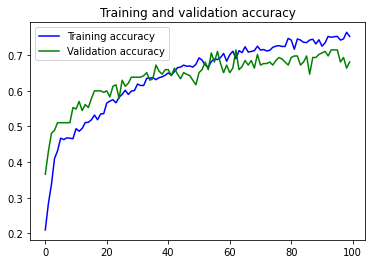

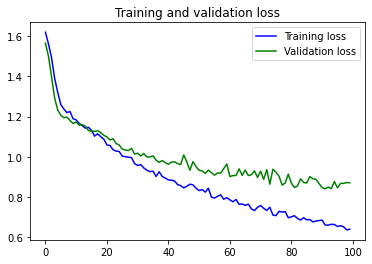

In [118]:
#model = load_model('name_of_model_to_load.h5')
epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [119]:
test_score = model.evaluate(test)
print(model.metrics_names)
print(test_score)
print()
print("Accuracy = ",test_score[1]*100,'%')

8/8 [==============================] - 1s 110ms/step - loss: 0.9054 - acc: 0.6426
['loss', 'acc']
[0.9054396748542786, 0.6425532102584839]

Accuracy =  64.25532102584839 %


In [169]:
tensorflow.keras.backend.clear_session()

In [170]:
from tensorflow.keras.applications import VGG16

In [171]:
pretrained_net = VGG16(input_shape=(100,100,3),include_top=False,weights='imagenet')

In [172]:
pretrained_net.summary()

19
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

In [173]:
for layer in pretrained_net.layers:
    layer.trainable=False

In [174]:
model = models.Sequential()
model.add(pretrained_net)
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [175]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 14,737,733
Trainable params: 23,045
Non-trainable params: 14,714,688
_________________________________________________________________


In [178]:
# compile model (and choose optimiser )
model.compile(loss=PARAMS['loss'],
              optimizer=optimizers.RMSprop(PARAMS['lr']),
              metrics=[PARAMS['metrics']])

In [181]:
# Fit the model 
spe=len(train)   # train_size/batch_size
epoch_num=PARAMS['n_epochs']
val_steps=len(validation)  # validation_size/batch_size


history = model.fit(
            train,
            steps_per_epoch=spe,  
            epochs=epoch_num,
            validation_data=validation,
            validation_steps=val_steps) 
#model.save(PARAMS['save_model'])

Epoch 1/50
40/40 [==============================] - 24s 594ms/step - loss: 1.6931 - acc: 0.2392 - val_loss: 1.4715 - val_acc: 0.3617
Epoch 2/50
40/40 [==============================] - 23s 587ms/step - loss: 1.3801 - acc: 0.4446 - val_loss: 1.2976 - val_acc: 0.5149
Epoch 3/50
40/40 [==============================] - 24s 600ms/step - loss: 1.2144 - acc: 0.5567 - val_loss: 1.1692 - val_acc: 0.5957
Epoch 4/50
40/40 [==============================] - 24s 597ms/step - loss: 1.0740 - acc: 0.6279 - val_loss: 1.0729 - val_acc: 0.6553
Epoch 5/50
40/40 [==============================] - 23s 588ms/step - loss: 1.0279 - acc: 0.6465 - val_loss: 1.0045 - val_acc: 0.6766
Epoch 6/50
40/40 [==============================] - 23s 586ms/step - loss: 0.9277 - acc: 0.6874 - val_loss: 0.9547 - val_acc: 0.6809
Epoch 7/50
40/40 [==============================] - 23s 580ms/step - loss: 0.8730 - acc: 0.7042 - val_loss: 0.9111 - val_acc: 0.6979
Epoch 8/50
40/40 [==============================] - 23s 574ms/step - 

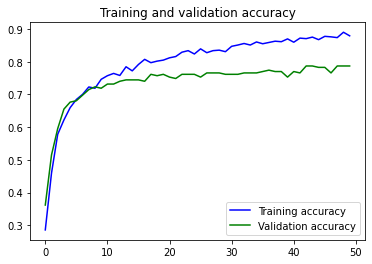

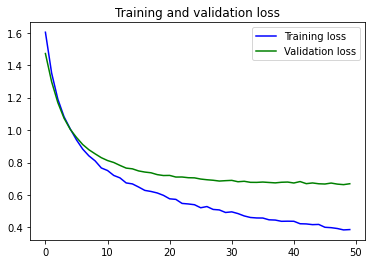

In [182]:
#model = load_model('name_of_model_to_load.h5')
epoch_num=PARAMS['n_epochs']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(range(epoch_num), acc, 'b', label='Training accuracy')
plt.plot(range(epoch_num), val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(epoch_num), loss, 'b', label='Training loss')
plt.plot(range(epoch_num), val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()